##### Copyright 2019 The TensorFlow Authors.

In [285]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [286]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [287]:
dataset = datasets.cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [288]:
# Import necessary libraries
from keras.datasets import cifar10
import numpy as np

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [289]:
from sklearn.utils import resample

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

print(len(frog_indices))
print(len(not_frog_indices))

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

print(len(downsampled_indices))

# Downsampled feature and label sets
train_images_downsampled = train_images[downsampled_indices]
train_labels_downsampled = train_labels[downsampled_indices]
train_labels_downsampled = np.where(train_labels_downsampled == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images_downsampled
train_labels = train_labels_downsampled

print(test_labels)
print(train_labels)

5000
45000
10000
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


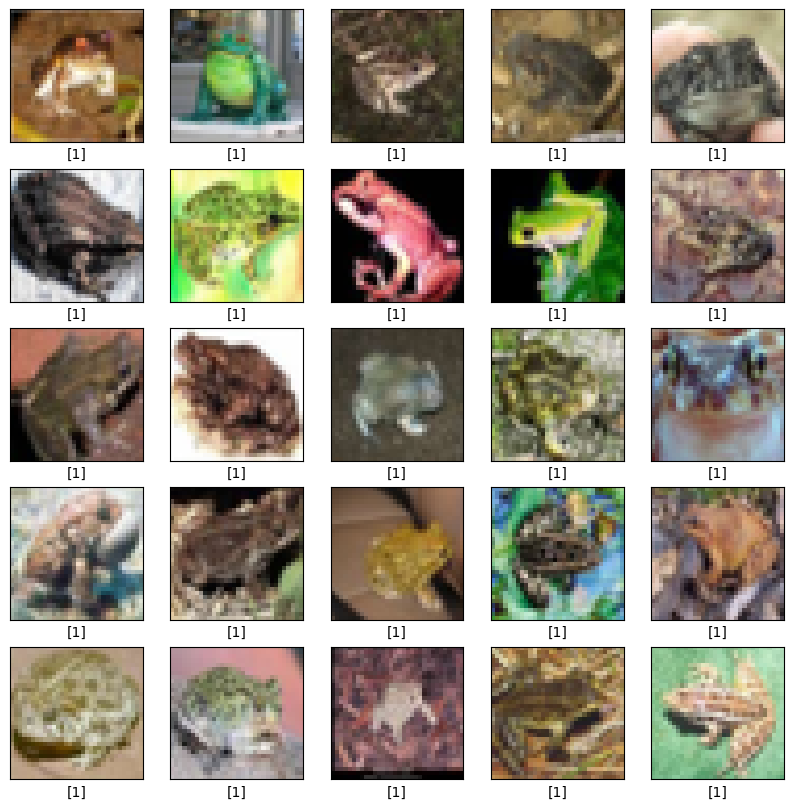

In [290]:
class_names = ['not_frog', 'frog']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_labels[i])
plt.show()

In [291]:
import pandas as pd

# Flatten the 3D array to 1D
flattened_train_labels = train_labels.flatten()
flattened_test_labels = test_labels.flatten()

# Convert the numpy array to a pandas DataFrame
#pd.DataFrame(flattened_train_labels).describe()
pd.DataFrame(flattened_test_labels).describe()

# Use the describe function

,0
count,10000.000000
mean,0.100000
std,0.300015
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [292]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Let's display the architecture of your model so far:

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

Here's the complete architecture of your model:

In [293]:
example_model = create_model()
example_model.summary()

/Users/josephcarnec/Documents/CIFAR/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,977 (480.38 KB)

 Trainable params: 122,977 (480.38 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [294]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}

ENSEMBLE_SIZE = 20

for i in range(ENSEMBLE_SIZE): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 1: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 2: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 3: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 4: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 5: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 6: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 7: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 8: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 9: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 10: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 11: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 12: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 13: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 14: {'accuracy': [], 'val_acc

In [295]:

for i in range(ENSEMBLE_SIZE):


    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(f'best_model_{i}.keras', monitor='val_loss', save_best_only=True)

    model = create_model()

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')])


    X_train_subset, y_train_subset = resample(train_images, train_labels)

    # Fit the model with the model checkpoint callback
    history = model.fit(X_train_subset, y_train_subset, epochs=100,
                        validation_data=(test_images, test_labels),
                        callbacks=[early_stopping, model_checkpoint])

    history_list[i].append(history)

    for history in history_list[i]:
        for key in history_dict_base.keys():
            history_dict[i][key].extend(history.history[key])

    print(history_dict)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7293 - auc_4: 0.7996 - loss: 0.5359 - val_accuracy: 0.7436 - val_auc_4: 0.9072 - val_loss: 0.4865
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8221 - auc_4: 0.9055 - loss: 0.3895 - val_accuracy: 0.8264 - val_auc_4: 0.9304 - val_loss: 0.3755
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8732 - auc_4: 0.9415 - loss: 0.3081 - val_accuracy: 0.8654 - val_auc_4: 0.9357 - val_loss: 0.3257
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8820 - auc_4: 0.9515 - loss: 0.2821 - val_accuracy: 0.8990 - val_auc_4: 0.9423 - val_loss: 0.2424
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9103 - auc_4: 0.9693 - loss: 0.2244 - val_accuracy: 0.8581 - val_auc_4: 0.9475 - val_loss: 0.3386
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9359 - auc_4: 0.9823 - loss: 0.1690 - val_accuracy: 0.8143 - val_auc_4: 0.9483 - val_loss: 0.4689
Epoch 7

### Evaluate the model

313/313 - 3s - 9ms/step - accuracy: 0.8990 - auc_4: 0.9423 - loss: 0.2424
313/313 - 2s - 6ms/step - accuracy: 0.9146 - auc_5: 0.9410 - loss: 0.2026
313/313 - 1s - 4ms/step - accuracy: 0.9034 - auc_6: 0.9270 - loss: 0.2212
313/313 - 1s - 4ms/step - accuracy: 0.9145 - auc_7: 0.9310 - loss: 0.2119
313/313 - 1s - 4ms/step - accuracy: 0.9223 - auc_8: 0.9387 - loss: 0.2260
313/313 - 1s - 4ms/step - accuracy: 0.9198 - auc_9: 0.9359 - loss: 0.1922
313/313 - 2s - 5ms/step - accuracy: 0.9067 - auc_10: 0.9461 - loss: 0.2509
313/313 - 1s - 4ms/step - accuracy: 0.9133 - auc_11: 0.9432 - loss: 0.2155
313/313 - 1s - 4ms/step - accuracy: 0.9057 - auc_12: 0.9474 - loss: 0.2301
313/313 - 1s - 4ms/step - accuracy: 0.9137 - auc_13: 0.9489 - loss: 0.2115
313/313 - 1s - 3ms/step - accuracy: 0.9022 - auc_14: 0.9451 - loss: 0.2500
313/313 - 1s - 3ms/step - accuracy: 0.8976 - auc_15: 0.9423 - loss: 0.2424
313/313 - 1s - 3ms/step - accuracy: 0.9304 - auc_16: 0.9492 - loss: 0.1986
313/313 - 1s - 3ms/step - accur

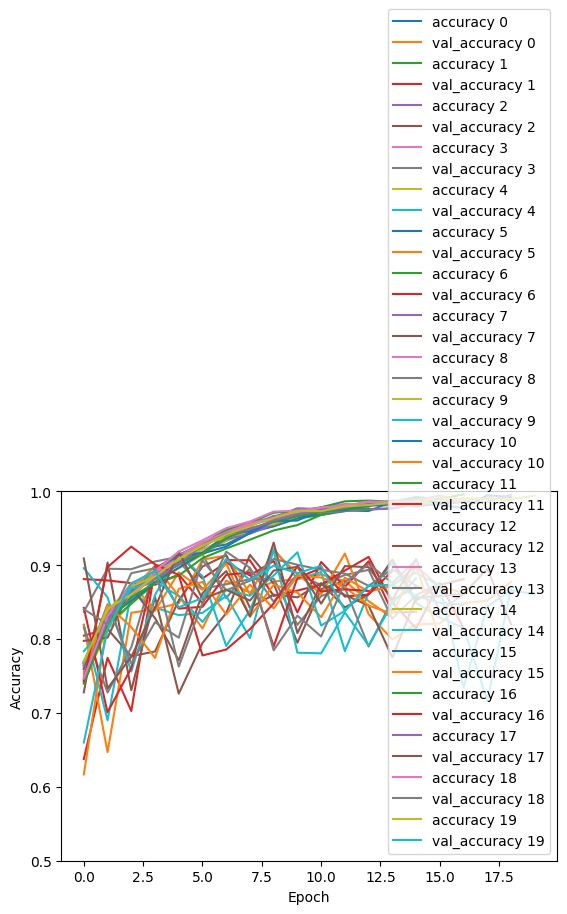

In [296]:
from tensorflow.keras.models import load_model

# Load the saved model

for i in range(ENSEMBLE_SIZE):
    model = load_model(f'best_model_{i}.keras')
    plt.plot(history_dict[i]['accuracy'], label=f'accuracy {i}')
    plt.plot(history_dict[i]['val_accuracy'], label = f'val_accuracy {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc, test_auc = model.evaluate(test_images,  test_labels, verbose=2)

In [297]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Average

class EnsembleModel(tf.keras.Model):
    def __init__(self, models, **kwargs):
        super(EnsembleModel, self).__init__(**kwargs)
        self.models = models

    def call(self, inputs):
        # Forward pass through each model
        outputs = [model(inputs) for model in self.models]

        # Average the outputs of each model
        # First, stack all model outputs
        outputs_stack = tf.stack(outputs, axis=0)

        # Then, calculate the mean along the first axis
        outputs_mean = tf.reduce_mean(outputs_stack, axis=0)

        return outputs_mean
    
    def verbose_predict(self, inputs):
        # Forward pass through each model
        outputs = [model(inputs) for model in self.models]

        # Stack all model outputs
        outputs_stack = tf.stack(outputs, axis=0)

        return outputs_stack


model_list = []

for i in range(ENSEMBLE_SIZE): 
    model_list.append(load_model(f"best_model_{i}.keras"))


# Create the ensemble model
ensemble_model = EnsembleModel(model_list)

# Compile the ensemble model
ensemble_model.compile(optimizer='adam',
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

# Evaluate the ensemble model
loss, accuracy = ensemble_model.evaluate(test_images, test_labels)
print('Ensemble accuracy:', accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9339 - loss: 0.1718
Ensemble accuracy: 0.9329000115394592


In [298]:


outputs_stack = ensemble_model.verbose_predict(test_images)
print(outputs_stack.shape)


(20, 10000, 1)


[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


(array([8713.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1287.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

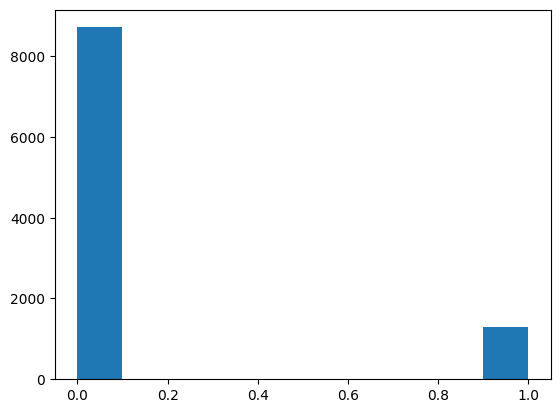

In [299]:

# Calculate the mean along the first axis
outputs_mean = tf.reduce_mean(outputs_stack, axis=0)
ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
print(ensemble_predictions)

plt.hist(ensemble_predictions.astype(int))



In [300]:
individual_predictions = np.where(outputs_stack > 0.5, 1, 0)
print(individual_predictions)
print(individual_predictions.shape)



[[[1]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]
(20, 10000, 1)


In [301]:

# Separate the correct and incorrect predictions
correct_prediction_indices = np.where(ensemble_predictions == test_labels)[0]
incorrect_prediction_indices = np.where(ensemble_predictions != test_labels)[0]
print(correct_prediction_indices)
print(incorrect_prediction_indices)

[   0    1    2 ... 9997 9998 9999]
[  15   52   53   59   65   71  103  110  118  125  140  142  147  152
  155  156  162  171  182  210  221  226  229  239  245  256  263  304
  309  322  336  354  400  405  420  428  450  458  459  465  500  509
  525  548  568  614  616  641  672  673  678  685  687  688  702  705
  761  762  770  779  807  848  862  870  889  893  900  926  980 1006
 1015 1032 1034 1035 1039 1058 1094 1147 1148 1173 1175 1178 1240 1245
 1249 1258 1292 1326 1394 1395 1403 1429 1443 1451 1453 1456 1513 1524
 1528 1530 1546 1554 1558 1572 1580 1582 1595 1606 1642 1678 1681 1710
 1731 1733 1737 1762 1788 1798 1837 1838 1846 1859 1911 1918 1935 1939
 1979 1986 2000 2003 2018 2019 2029 2037 2065 2068 2072 2078 2081 2123
 2128 2157 2163 2168 2212 2226 2242 2251 2261 2310 2312 2342 2350 2353
 2405 2412 2413 2416 2423 2435 2442 2444 2453 2499 2500 2506 2547 2558
 2577 2581 2599 2618 2632 2635 2641 2642 2662 2671 2676 2690 2695 2735
 2754 2788 2800 2825 2829 2849 2851 2934 

(array([479.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 192.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

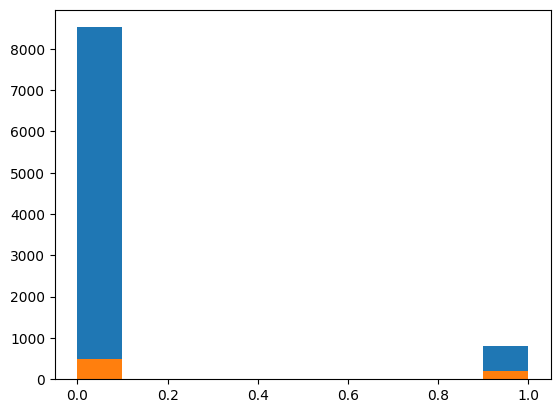

In [302]:
correct_predictions = test_labels[correct_prediction_indices]
incorrect_predictions = test_labels[incorrect_prediction_indices]
plt.hist(correct_predictions)
plt.hist(incorrect_predictions)


In [303]:

print(correct_prediction_indices)
print(test_labels)
positive_label_indices = np.where(test_labels == 1)[0]
negative_label_indices = np.where(test_labels == 0)[0]
true_positive_indices = np.intersect1d(positive_label_indices, correct_prediction_indices)
true_negative_indices = np.intersect1d(negative_label_indices, correct_prediction_indices)

print(true_positive_indices.shape)
print(true_negative_indices.shape)
print(correct_prediction_indices.shape)

[   0    1    2 ... 9997 9998 9999]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
(808,)
(8521,)
(9329,)


In [304]:

false_negative_indices = np.intersect1d(positive_label_indices, incorrect_prediction_indices)
false_positive_indices = np.intersect1d(negative_label_indices, incorrect_prediction_indices)

print(false_negative_indices.shape)
print(false_positive_indices.shape)
print(incorrect_prediction_indices.shape)


(192,)
(479,)
(671,)


In [305]:
for i in range(100):
    tn = true_negative_indices[i]
    print(f'tn: ensemble_predictions: {ensemble_predictions[tn]}, label: {test_labels[tn]}')

for i in range(100):
    fp = false_positive_indices[i]
    print(f'fp: ensemble_predictions: {ensemble_predictions[fp]}, label: {test_labels[fp]}')


for i in range(100):
    fn = false_negative_indices[i]
    print(f'fn: ensemble_predictions: {ensemble_predictions[fn]}, label: {test_labels[fn]}')


for i in range(100):
    tp = true_positive_indices[i]
    print(f'tp: ensemble_predictions: {ensemble_predictions[tp]}, label: {test_labels[tp]}')


tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], label: [0]
tn: ensemble_predictions: [0], lab

In [306]:

true_positives = np.random.choice(true_positive_indices, 16, replace=False)

for i in true_positives:
    print(f'fp: softpred: {outputs_mean[i]} ensemble_predictions: {ensemble_predictions[i]}, label: {test_labels[i]}')

fp: softpred: [0.9208881] ensemble_predictions: [1], label: [1]
fp: softpred: [0.7300949] ensemble_predictions: [1], label: [1]
fp: softpred: [0.9565951] ensemble_predictions: [1], label: [1]
fp: softpred: [0.8537542] ensemble_predictions: [1], label: [1]
fp: softpred: [0.8806723] ensemble_predictions: [1], label: [1]
fp: softpred: [0.826244] ensemble_predictions: [1], label: [1]
fp: softpred: [0.9304055] ensemble_predictions: [1], label: [1]
fp: softpred: [0.85149366] ensemble_predictions: [1], label: [1]
fp: softpred: [0.7198426] ensemble_predictions: [1], label: [1]
fp: softpred: [0.89680976] ensemble_predictions: [1], label: [1]
fp: softpred: [0.95774156] ensemble_predictions: [1], label: [1]
fp: softpred: [0.68912876] ensemble_predictions: [1], label: [1]
fp: softpred: [0.93970424] ensemble_predictions: [1], label: [1]
fp: softpred: [0.98237246] ensemble_predictions: [1], label: [1]
fp: softpred: [0.94656533] ensemble_predictions: [1], label: [1]
fp: softpred: [0.99336493] ensembl

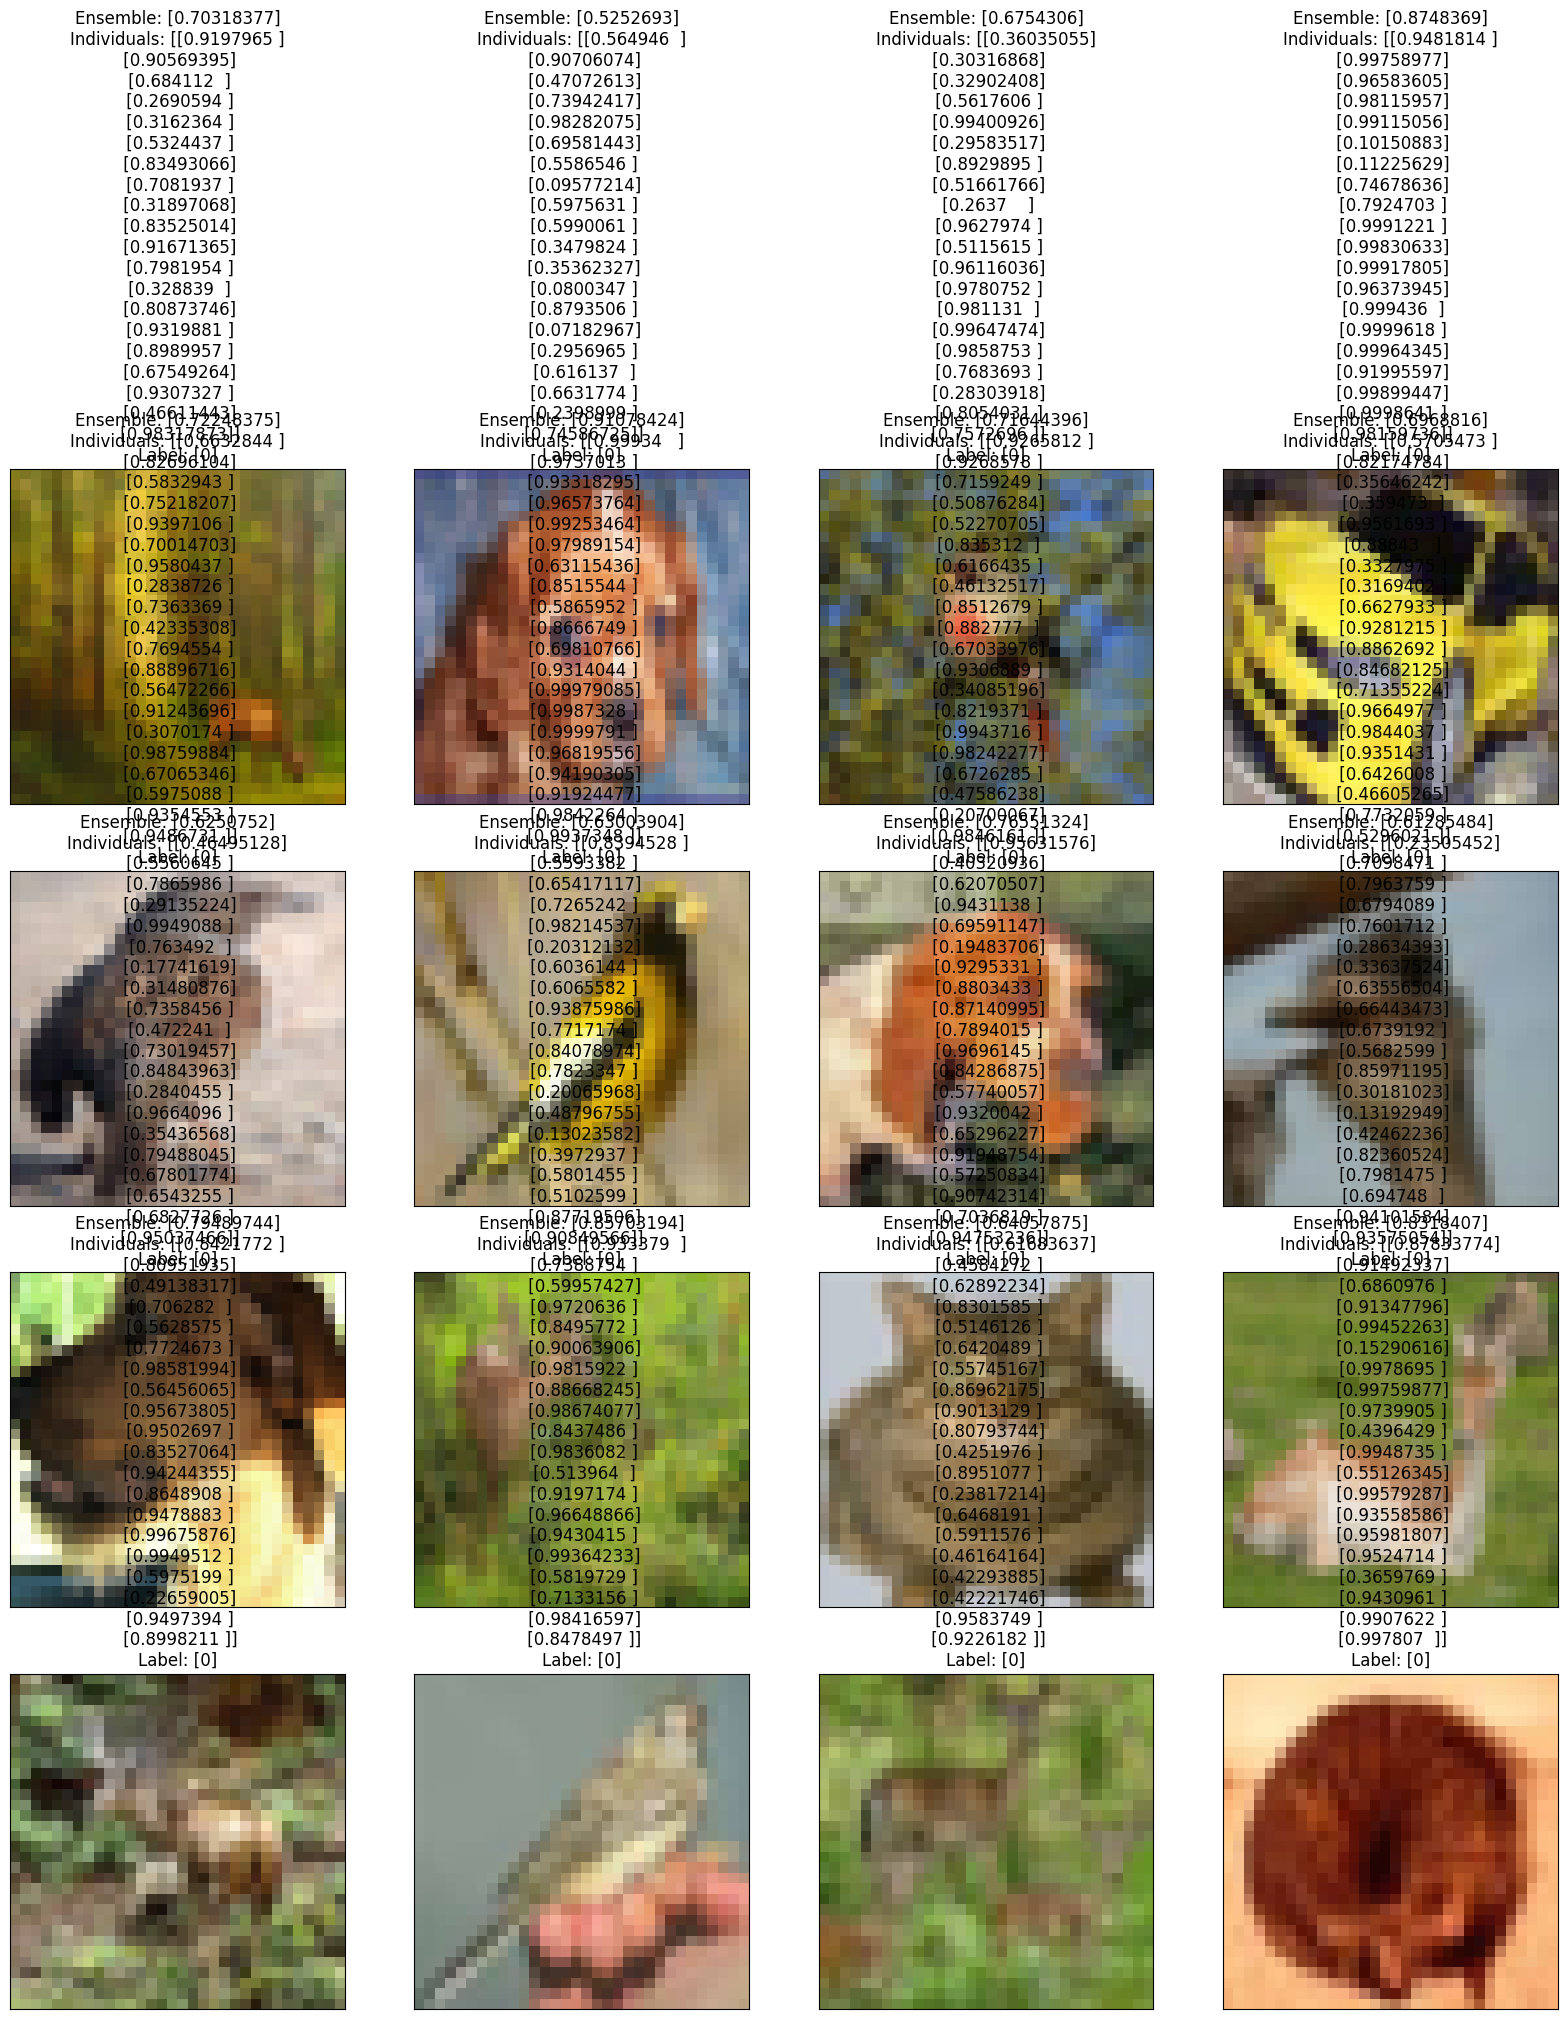

In [307]:

# Randomly select 50 correct and 50 incorrect predictions
true_positives = np.random.choice(true_positive_indices, 16, replace=False)
false_positives = np.random.choice(false_positive_indices, 16, replace=False)

import matplotlib.pyplot as plt

# Create a 10x10 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    # Get the index of the current image
    index = false_positives[i]

    # Display the image
    ax.imshow(test_images[index], cmap='gray')

    # Get the predictions of the individual models and the ensemble
    # 2 x 10000 x 1
    individual_pred = outputs_stack[:, index]
    ensemble_pred = outputs_mean[index]

    # Display the predictions
    ax.set_title(f'Ensemble: {ensemble_pred}\nIndividuals: {individual_pred}\nLabel: {test_labels[index]}')

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()



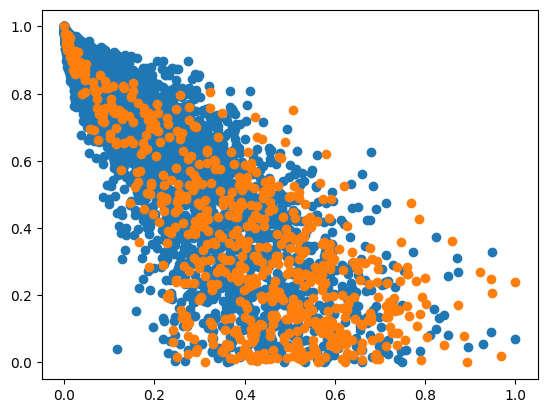

In [309]:


output_variance = tf.math.reduce_variance(outputs_stack, axis=0)
outputs_mean = tf.math.reduce_mean(outputs_stack, axis=0)
output_confidence = tf.abs(outputs_mean - 0.5)

# Ensure indices are TensorFlow tensors for compatibility
correct_prediction_indices = tf.convert_to_tensor(correct_prediction_indices, dtype=tf.int32)
incorrect_prediction_indices = tf.convert_to_tensor(incorrect_prediction_indices, dtype=tf.int32)

# Using tf.gather to filter tensors based on indices
x = tf.gather(output_variance, correct_prediction_indices)
y = tf.gather(output_confidence, correct_prediction_indices)


x2 = tf.gather(output_variance, incorrect_prediction_indices)
y2 = tf.gather(output_confidence, incorrect_prediction_indices)

# Convert to numpy for plotting
x_numpy = x.numpy()
y_numpy = y.numpy()

# Normalize x and y
x_numpy_normalized = (x_numpy - x_numpy.min()) / (x_numpy.max() - x_numpy.min())
y_numpy_normalized = (y_numpy - y_numpy.min()) / (y_numpy.max() - y_numpy.min())

# Plotting
plt.scatter(x_numpy_normalized, y_numpy_normalized)

# Convert to numpy for plotting
x2_numpy = x2.numpy()
y2_numpy = y2.numpy()

# Normalize x2 and y2
x2_numpy_normalized = (x2_numpy - x2_numpy.min()) / (x2_numpy.max() - x2_numpy.min())
y2_numpy_normalized = (y2_numpy - y2_numpy.min()) / (y2_numpy.max() - y2_numpy.min())

plt.scatter(x2_numpy_normalized, y2_numpy_normalized)